In [2]:
import argparse
from copy import copy

import torch
import torch_geometric.transforms as T

from torch_geometric import seed_everything
from torch_geometric.datasets import OGB_MAG, HGBDataset, RCDD
from torch_geometric.loader import ImbalancedSampler, NeighborLoader
from torch_geometric.utils import sort_edge_index, index_to_mask

# custom modules
from hetero2net.dataset import load_dataset
from hetero2net.logger import setup_logger
from hetero2net.models import HeteroGNN
from hetero2net.lr_scheduler import get_cosine_schedule_with_warmup
from hetero2net.utils import (evaluate_full_batch,
                              evaluate_mini_batch,
                              train_full_batch,
                              train_mini_batch,
                              tab_printer)


In [9]:
acm,acm_metapath=load_dataset('ACM')
print(acm)
print(acm.edge_types)
print('acm_metapath',acm_metapath)
print(acm.edge_index_dict['paper','cite','paper'])
print(acm.edge_index_dict['paper','cite','paper'].size())

HeteroData(
  paper={
    x=[3025, 1902],
    y=[3025],
    train_mask=[3025],
    test_mask=[3025],
    val_mask=[3025],
  },
  author={ x=[5959, 1902] },
  subject={ x=[56, 1902] },
  term={
    num_nodes=1902,
    x=[1902, 1],
  },
  (paper, cite, paper)={ edge_index=[2, 5343] },
  (paper, ref, paper)={ edge_index=[2, 5343] },
  (paper, to, author)={ edge_index=[2, 9949] },
  (author, to, paper)={ edge_index=[2, 9949] },
  (paper, to, subject)={ edge_index=[2, 3025] },
  (subject, to, paper)={ edge_index=[2, 3025] },
  (paper, to, term)={ edge_index=[2, 255619] },
  (term, to, paper)={ edge_index=[2, 255619] }
)
[('paper', 'cite', 'paper'), ('paper', 'ref', 'paper'), ('paper', 'to', 'author'), ('author', 'to', 'paper'), ('paper', 'to', 'subject'), ('subject', 'to', 'paper'), ('paper', 'to', 'term'), ('term', 'to', 'paper')]
acm_metapath [[('author', 'paper'), ('paper', 'author')], [('author', 'paper'), ('paper', 'term'), ('term', 'paper'), ('paper', 'author'), ('paper', 'paper')]]
t

In [10]:
import hetero2net.homophily as homo

dataset = 'DBLP'
data, metapaths = load_dataset(dataset)

data,metapaths

(HeteroData(
   author={
     x=[4057, 334],
     y=[4057],
     train_mask=[4057],
     test_mask=[4057],
     val_mask=[4057],
   },
   paper={ x=[14328, 4231] },
   term={ x=[7723, 50] },
   venue={
     num_nodes=20,
     x=[20, 20],
   },
   (author, to, paper)={ edge_index=[2, 19645] },
   (paper, to, term)={ edge_index=[2, 85810] },
   (paper, to, venue)={ edge_index=[2, 14328] },
   (paper, to, author)={ edge_index=[2, 19645] },
   (term, to, paper)={ edge_index=[2, 85810] },
   (venue, to, paper)={ edge_index=[2, 14328] }
 ),
 [[('paper', 'author'), ('author', 'paper')],
  [('author', 'paper'),
   ('paper', 'venue'),
   ('venue', 'paper'),
   ('paper', 'author')]])

In [8]:
# 结点特征数据
for name, value in data.x_dict.items():
    print(name,value.size())
#data.x_dict



author torch.Size([4057, 334])
paper torch.Size([14328, 4231])
term torch.Size([7723, 50])
venue torch.Size([20, 20])


In [9]:
# 边数据
# 第一行存储每条边的起始量的索引  第二行存储每条边的终止量的索引
for name, value in data.edge_index_dict.items():
    print(name,value.size())

print(data.edge_index_dict['author', 'to', 'paper'])

('author', 'to', 'paper') torch.Size([2, 19645])
('paper', 'to', 'term') torch.Size([2, 85810])
('paper', 'to', 'venue') torch.Size([2, 14328])
('paper', 'to', 'author') torch.Size([2, 19645])
('term', 'to', 'paper') torch.Size([2, 85810])
('venue', 'to', 'paper') torch.Size([2, 14328])
tensor([[    0,     0,     1,  ...,  4054,  4055,  4056],
        [ 2364,  6457,  2365,  ..., 13891, 13891, 13892]])


In [10]:
data.edge_index_dict['author','to','paper']

tensor([[    0,     0,     1,  ...,  4054,  4055,  4056],
        [ 2364,  6457,  2365,  ..., 13891, 13891, 13892]])

In [21]:
for edge_type, edge_index in data.edge_index_dict.items():
    print(edge_type)
    src, rel, dst = edge_type
    print(src,rel,dst)

('author', 'to', 'paper')
author to paper
('paper', 'to', 'term')
paper to term
('paper', 'to', 'venue')
paper to venue
('paper', 'to', 'author')
paper to author
('term', 'to', 'paper')
term to paper
('venue', 'to', 'paper')
venue to paper


In [ ]:
'''
# 论文属性（2篇论文，3维特征）
x = tensor([[0.9, 0.1, 0.5], 
            [0.8, 0.2, 0.6]])

# 作者→论文的边（作者0写论文0，作者1写论文1）
edge_index = tensor([[0, 1],
                    [0, 1]])

# 计算属性同质性
衡量图中每个节点的邻居与它在属性空间中是否相似（即“属性同配性”）
print(homo.attribute_homophily(edge_index, x))  
# 输出: 0.0025（值小，说明两篇论文属性相似）
'''

edge_index = data[('author','to','paper')]['edge_index']
x = data['author']['x']

#print(homo.attribute_homophily(edge_index,x))
print('x',x)
print('edge_index',edge_index)
print(data[('author','to','paper')]['edge_index'])
print('data数据是:\n',data)



x tensor([[0.0000, 0.0000, 0.1429,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])
edge_index tensor([[    0,     0,     1,  ...,  4054,  4055,  4056],
        [ 2364,  6457,  2365,  ..., 13891, 13891, 13892]])
tensor([[    0,     0,     1,  ...,  4054,  4055,  4056],
        [ 2364,  6457,  2365,  ..., 13891, 13891, 13892]])
data数据是:
 HeteroData(
  author={
    x=[4057, 334],
    y=[4057],
    train_mask=[4057],
    test_mask=[4057],
    val_mask=[4057],
  },
  paper={ x=[14328, 4231] },
  term={ x=[7723, 50] },
  venue={
    num_nodes=20,
    x=[20, 20],
  },
  (author, to, paper)={ edge_index=[2, 19645] },
  (paper, to, term)={ edge_index=[2, 85810] },
  (paper, to, venue

In [28]:
# print(data)
print(homo.attribute_homophily(data[('term', 'to', 'paper')]['edge_index'],data['paper']['x']))
a = homo.attribute_homophily_matrix(data[('author', 'to', 'paper')]['edge_index'],data['paper']['x'])
print(homo.attribute_homophily_matrix(data[('author', 'to', 'paper')]['edge_index'],data['paper']['x']))
print(a.size())
#print(homo.label_homophily(data[('paper', 'to', 'author')]['edge_index'],data['paper']['y']))

data['author']['y'].size()

print(data['paper']['x'].size())
print(data['author']['x'].size())
print(homo.attribute_homophily_matrix(data[('paper', 'to', 'author')]['edge_index'],data['paper']['x']))

0.009697876870632172
tensor([0.0625, 0.0415, 0.0166,  ..., 0.0493, 0.0332, 0.0083])
torch.Size([14328])
torch.Size([14328, 4231])
torch.Size([4057, 334])
tensor([0.0527, 0.0375, 0.0276,  ..., 0.0000, 0.0000, 0.0000])


In [ ]:
a

In [14]:
a

tensor([0.0625, 0.0415, 0.0166,  ..., 0.0493, 0.0332, 0.0083])

In [15]:
parser = argparse.ArgumentParser()
parser

ArgumentParser(prog='ipykernel_launcher.py', usage=None, description=None, formatter_class=<class 'argparse.HelpFormatter'>, conflict_handler='error', add_help=True)

显示数据集同配性指标？

In [23]:
import matplotlib.pyplot as plt
import os

# 计算数据集所有节点的同配性指标
def calculate_all_homophily(data):
    homophily_values = []
    for edge_type in data.edge_types:
        print(edge_type)
        edge_index = data.edge_index_dict[edge_type]
        node_type = edge_type[2]  # 取边类型中的源节点类型
        print(node_type)
        if node_type in data.x_dict:
            node_features = data.x_dict[node_type]
            homophily = homo.attribute_homophily(edge_index, node_features)
            homophily_values.append(homophily)
    return homophily_values

# 加载数据集
acm_data,acm_metapath = load_dataset('ACM')
dblp_data,dblp_metapath = load_dataset('DBLP')
imdb_data,imdb_metapath = load_dataset('IMDB')

# 计算同配性
acm_homophily = calculate_all_homophily(acm_data)
dblp_homophily = calculate_all_homophily(dblp_data)
imdb_homophily = calculate_all_homophily(imdb_data)

# 绘制同配性分布
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(acm_homophily, bins=20)
plt.title('ACM Homophily Distribution')
plt.xlabel('Homophily')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(dblp_homophily, bins=20)
plt.title('DBLP Homophily Distribution')
plt.xlabel('Homophily')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.hist(imdb_homophily, bins=20)
plt.title('IMDB Homophily Distribution')
plt.xlabel('Homophily')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

('paper', 'cite', 'paper')
paper
('paper', 'ref', 'paper')
paper
('paper', 'to', 'author')
author


KeyError: 'author'

基于自定义metapath计算指标

In [41]:
import torch
import matplotlib.pyplot as plt
from collections import defaultdict
from torch_geometric.utils import degree, subgraph
from torch_scatter import scatter

def attribute_homophily_matrix(edge_index, x_src, x_dst):
    """
    计算每个目标节点的同配性指标：其邻居源节点的属性距离的平均值。
    """
    row, col = edge_index  # row 是源，col 是目标
    src_deg = degree(row, num_nodes=x_src.size(0)).clamp(min=1)
    dst_deg = degree(col, num_nodes=x_dst.size(0)).clamp(min=1)

    # 对每条边计算能量（属性差异）
    energy = (x_src[row] / src_deg[row].sqrt().unsqueeze(-1)) - \
             (x_dst[col] / dst_deg[col].sqrt().unsqueeze(-1))
    energy = energy.norm(p=2, dim=1).pow(2) / 4.0  # scalar
    homophily_per_node = scatter(energy, col, dim=0, dim_size=x_dst.size(0), reduce='mean')
    return homophily_per_node


def calculate_node_homophily_via_metapath(data, metapaths):
    """
    返回每个节点在所有 metapath 下的平均同配性指标。
    """
    node_scores = defaultdict(list)
    for edge_index in data.edge_index_dict:
        print(edge_index)
    for metapath in metapaths:
        
        # 依次连接 metapath 的边，得到最终的同构视图
        edge_index = data[metapath[0]].edge_index
        print(edge_index)
        for edge_type in metapath[1:]:
            next_edge_index = data[edge_type].edge_index
            # 匹配路径连接的目标和源，这里假设是连续可连接的
            mapping = {}
            for i in range(edge_index.size(1)):
                for j in range(next_edge_index.size(1)):
                    if edge_index[1, i] == next_edge_index[0, j]:
                        mapping.setdefault(edge_index[0, i].item(), []).append(next_edge_index[1, j].item())

            # flatten new edge_index
            new_rows, new_cols = [], []
            for k, vs in mapping.items():
                for v in vs:
                    new_rows.append(k)
                    new_cols.append(v)
            edge_index = torch.tensor([new_rows, new_cols], device=edge_index.device)

        # 取得起点和终点节点类型
        src_type = metapath[0][0]
        dst_type = metapath[-1][2]

        if src_type in data.x_dict and dst_type in data.x_dict:
            x_src = data.x_dict[src_type]
            x_dst = data.x_dict[dst_type]

            # 计算同配性
            homo_score = attribute_homophily_matrix(edge_index, x_src, x_dst)

            # 累积每个目标节点的同配性指标
            for i, score in enumerate(homo_score):
                node_scores[f"{dst_type}_{i}"].append(score.item())

    # 平均所有 metapath 下的得分
    all_scores = [sum(scores)/len(scores) for scores in node_scores.values()]
    return all_scores


calculate_node_homophily_via_metapath(acm_data, acm_metapath)


('paper', 'cite', 'paper')
('paper', 'ref', 'paper')
('paper', 'to', 'author')
('author', 'to', 'paper')
('paper', 'to', 'subject')
('subject', 'to', 'paper')
('paper', 'to', 'term')
('term', 'to', 'paper')
tensor([[   0,    0,    0,  ..., 5956, 5957, 5958],
        [   0,  734, 3015,  ..., 3024, 3024, 3024]])


KeyboardInterrupt: 

已知edge_index情况下针对边连接计算指标【已经废弃，仍然计算不同类型节点】

In [55]:
import torch
from collections import defaultdict
import torch.nn.functional as F

def attribute_homophily_matrix(edge_index, x_src, x_dst):
    src_nodes = edge_index[0]
    dst_nodes = edge_index[1]

    node_score_dict = defaultdict(list)

    for s, d in zip(src_nodes.tolist(), dst_nodes.tolist()):
        sim = F.cosine_similarity(x_src[s], x_dst[d], dim=0)  # 范围 [-1, 1]
        sim = (sim + 1) / 2  # 归一化为 [0, 1]
        node_score_dict[d].append(sim.item())

    homophily_scores = torch.zeros(x_dst.size(0))
    for node_id, sims in node_score_dict.items():
        homophily_scores[node_id] = sum(sims) / len(sims)

    return homophily_scores


def calculate_node_homophily_via_edge_type(data):
    node_scores = defaultdict(list)

    for edge_type in data.edge_types:
        src_type, rel_type, dst_type = edge_type
        edge_index = data[edge_type].edge_index

        print(f"Processing edge type: {edge_type} with {edge_index.shape[1]} edges")

        if src_type in data.x_dict and dst_type in data.x_dict:
            x_src = data.x_dict[src_type]
            x_dst = data.x_dict[dst_type]

            homo_score = attribute_homophily_matrix(edge_index, x_src, x_dst)

            for i, score in enumerate(homo_score):
                node_scores[f"{dst_type}_{i}"].append(score.item())

    # 每个节点同配性 = 所有边类型下的平均
    final_scores = []
    for node_id, scores in node_scores.items():
        avg_score = sum(scores) / len(scores)
        final_scores.append(avg_score)

    return final_scores


In [ ]:
import torch
from collections import defaultdict
import torch.nn.functional as F
import time

def attribute_homophily_from_src_view(edge_index, x_src, x_dst):
    """
    对于每个源节点，计算其连接的目标节点在属性上的平均相似度（源视角的同配性）
    """
    src_nodes = edge_index[0]
    dst_nodes = edge_index[1]

    src_score_dict = defaultdict(list)

    for s, d in zip(src_nodes.tolist(), dst_nodes.tolist()):
        sim = F.cosine_similarity(x_src[s], x_dst[d], dim=0)  # [-1, 1]
        sim = (sim + 1) / 2  # scale to [0, 1]
        src_score_dict[s].append(sim.item())

    homophily_scores = torch.zeros(x_src.size(0))

    for src_id, sims in src_score_dict.items():
        homophily_scores[src_id] = sum(sims) / len(sims)

    return homophily_scores

def attribute_homophily_dst_set_similarity(edge_index, x_src, x_dst):
    """
    对每个源节点，计算其所有连接的目标节点之间的两两相似度平均值，作为该源节点的同配性指标。
    """
    src_nodes = edge_index[0]
    dst_nodes = edge_index[1]

    src_to_dsts = defaultdict(list)

    # 收集每个源节点连接的所有目标节点
    for s, d in zip(src_nodes.tolist(), dst_nodes.tolist()):
        src_to_dsts[s].append(d)

    homophily_scores = torch.zeros(x_src.size(0))

    for src_id, dst_list in src_to_dsts.items():
        if len(dst_list) < 2:
            # 如果连接目标少于两个，不足以计算相似性
            homophily_scores[src_id] = 0.0
            continue

        sims = []
        for i in range(len(dst_list)):
            for j in range(i + 1, len(dst_list)):
                d1 = dst_list[i]
                d2 = dst_list[j]
                sim = F.cosine_similarity(x_dst[d1], x_dst[d2], dim=0)
                sim = (sim + 1) / 2  # [-1,1] -> [0,1]
                sims.append(sim.item())

        homophily_scores[src_id] = sum(sims) / len(sims)

    return homophily_scores

def calculate_src_node_homophily_by_edge_type(data):
    """
    返回两个结果：
    1. node_scores: 字典结构，表示每种源节点类型的平均同配性列表
    2. all_scores: 所有类型源节点的同配性拼接为一个总列表（用于整体分布分析）
    """
    from collections import defaultdict
    node_scores = defaultdict(list)
    all_scores = []
    total_start = time.time()

    for edge_type in data.edge_types:
        edge_start = time.time()

        src_type, rel_type, dst_type = edge_type
        edge_index = data[edge_type].edge_index

        print(f"🚀 Processing edge type: {edge_type}, edges: {edge_index.shape[1]}")

        if src_type in data.x_dict and dst_type in data.x_dict:
            x_src = data.x_dict[src_type]
            x_dst = data.x_dict[dst_type]

            #homophily = attribute_homophily_from_src_view(edge_index, x_src, x_dst)
            homophily = attribute_homophily_dst_set_similarity(edge_index,x_src,x_dst)
            homo_list = homophily.tolist()

            # 合并进每种类型的字典
            if src_type in node_scores:
                old = node_scores[src_type]
                if len(old) == len(homo_list):
                    node_scores[src_type] = [(a + b) / 2 for a, b in zip(old, homo_list)]
                else:
                    max_len = max(len(old), len(homo_list))
                    old += [0.0] * (max_len - len(old))
                    new = homo_list + [0.0] * (max_len - len(homo_list))
                    node_scores[src_type] = [(a + b) / 2 for a, b in zip(old, new)]
            else:
                node_scores[src_type] = homo_list

            # 所有指标追加进总表
            all_scores.extend(homo_list)

        edge_end = time.time()
        print(f"⏱️ Edge type {edge_type} processed in {edge_end - edge_start:.2f} seconds.\n")

    total_end = time.time()
    print(f"🕒 Total processing time: {total_end - total_start:.2f} seconds.")


    return all_scores,node_scores



In [75]:
# 加载数据和 metapath
acm_data, acm_metapath = load_dataset('ACM')

# 计算每个节点的平均同配性指标
#acm_homophily = calculate_node_homophily_via_edge_type(acm_data)
acm_homophily,acm_node_homophily = calculate_src_node_homophily_by_edge_type(acm_data)


🚀 Processing edge type: ('paper', 'cite', 'paper'), edges: 5343
🚀 Processing edge type: ('paper', 'ref', 'paper'), edges: 5343
🚀 Processing edge type: ('paper', 'to', 'author'), edges: 9949
🚀 Processing edge type: ('author', 'to', 'paper'), edges: 9949
🚀 Processing edge type: ('paper', 'to', 'subject'), edges: 3025
🚀 Processing edge type: ('subject', 'to', 'paper'), edges: 3025
🚀 Processing edge type: ('paper', 'to', 'term'), edges: 255619
🚀 Processing edge type: ('term', 'to', 'paper'), edges: 255619


[0.6625932455062866, 0.6638236045837402, 0.6535829305648804, 0.6602079272270203, 0.652301549911499, 0.0, 0.6474010944366455, 0.6527478694915771, 0.656761109828949, 0.6357484459877014, 0.6336854696273804, 0.701041579246521, 0.6243874430656433, 0.0, 0.0, 0.0, 0.6634538769721985, 0.6698545813560486, 0.7057694792747498, 0.6387039422988892, 0.0, 0.0, 0.6059625744819641, 0.688138484954834, 0.6423336863517761, 0.6471115946769714, 0.6468936204910278, 0.6289929151535034, 0.0, 0.632781982421875, 0.6408476233482361, 0.6761578321456909, 0.6779965162277222, 0.6545719504356384, 0.0, 0.634908139705658, 0.6514695882797241, 0.0, 0.0, 0.6273075342178345, 0.6669244766235352, 0.0, 0.6719362735748291, 0.6373957991600037, 0.651398777961731, 0.6890263557434082, 0.6545354723930359, 0.6829279661178589, 0.0, 0.6424094438552856, 0.6784018278121948, 0.6438265442848206, 0.6356473565101624, 0.0, 0.7727311849594116, 0.6877133250236511, 0.6242983341217041, 0.0, 0.6472631096839905, 0.6277892589569092, 0.66025614738464

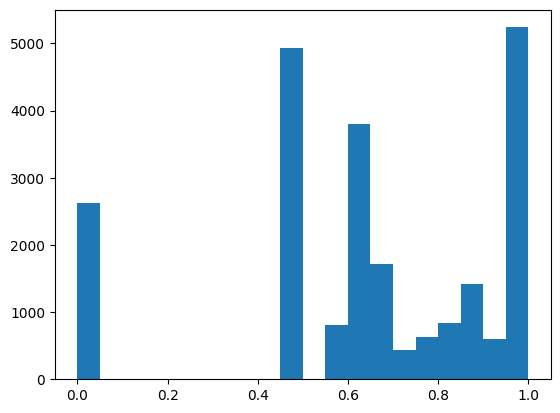

In [85]:
print(acm_homophily)
print(acm_data.num_nodes)
len(acm_homophily)
a = torch.tensor(acm_homophily)
print(a[a<0].numel())
plt.hist(acm_homophily, bins=20)
plt.show()

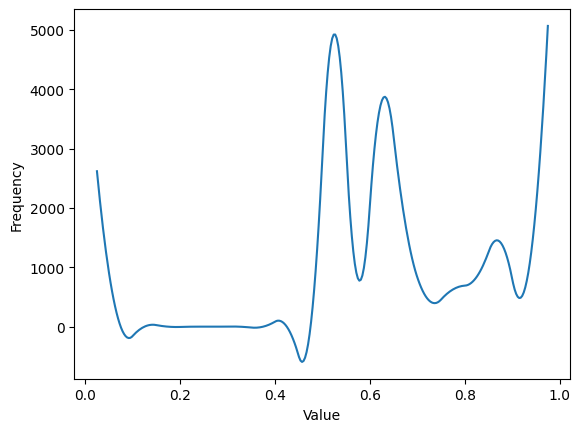

In [93]:
import numpy as np
from scipy.interpolate import interp1d
def figure_plot_homo(homophily, bins=20):
    # 生成 0 - 1 的分箱边界
    bin_edges = np.linspace(0, 1, bins + 1)
    # 统计每个分箱内的数据数量
    hist, _ = np.histogram(homophily, bins=bin_edges)

    # 计算每个分箱的中心位置
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # 创建插值函数
    #f = interp1d(bin_centers, hist, kind='cubic')
    # 二次
    f = interp1d(bin_centers, hist, kind='quadratic')
    # 线性
    # f = interp1d(bin_centers, hist, kind='linear')


    # 生成更密集的 x 值用于绘制平滑曲线
    x_new = np.linspace(bin_centers.min(), bin_centers.max(), 300)
    y_new = f(x_new)
    # 绘制平滑曲线
    plt.plot(x_new, y_new)

    # 添加标签
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    
figure_plot_homo(acm_homophily)

In [100]:
# 加载数据和 metapath（你已有）
acm_data, acm_metapath = load_dataset('ACM')
dblp_data, dblp_metapath = load_dataset('DBLP')
imdb_data, imdb_metapath = load_dataset('IMDB')

# 计算每个节点的平均同配性指标
dblp_homophily = calculate_src_node_homophily_by_edge_type(dblp_data)
#imdb_homophily = calculate_src_node_homophily_by_edge_type(imdb_data)
#acm_homophily = calculate_src_node_homophily_by_edge_type(acm_data)



🚀 Processing edge type: ('author', 'to', 'paper'), edges: 19645
🚀 Processing edge type: ('paper', 'to', 'term'), edges: 85810
🚀 Processing edge type: ('paper', 'to', 'venue'), edges: 14328
🚀 Processing edge type: ('paper', 'to', 'author'), edges: 19645
🚀 Processing edge type: ('term', 'to', 'paper'), edges: 85810
🚀 Processing edge type: ('venue', 'to', 'paper'), edges: 14328


In [101]:
figure_plot_homo(dblp_homophily)

d:\APP\Python\anaconda3\envs\gpu\lib\site-packages\numpy\lib\histograms.py:285: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.asarray(a)


TypeError: '<' not supported between instances of 'collections.defaultdict' and 'list'

In [ ]:
# 绘图
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
figure_plot_homo(acm_homophily, bins=20)
plt.title('ACM Homophily Distribution')

plt.subplot(1, 3, 2)
figure_plot_homo(dblp_homophily, bins=20)
plt.title('DBLP Homophily Distribution')

plt.subplot(1, 3, 3)
figure_plot_homo(imdb_homophily, bins=20)
plt.title('IMDB Homophily Distribution')

plt.tight_layout()
plt.show()